# NPZD slab model

For the first model example I will need:
- Forcing input
- Forcing_fluxes:
    - mixing
    - sinking
- 4 components (single) N, P, Z, D
- Fluxes:
TODO: GO OVER THE equations! Base model structure in math!
    - Grazing - linked to all NPZD
    - PhytoplanktonGrowth
        - Light - Dependence
        - Nutrients - Dependence
        - Temp - Dependence
    - mortality
    - remineralisation
    - higher order pred, etc

N = Mixing(N0-N)+LeakyGrazing(P,D)+Remin(D)-Growth(P)
P = Growth(P)-Mortality(P)-QuadMort(P)-Grazing(P)-Mixing(P)
Z = Grazing(P,D)-Mortality(Z)-QuadMort(Z)-Mixing(Z)
D = Mortality(P)+QuadMort(P)+Mortality(Z)+SloppyGrazing(P,D)-Grazing(D)-Remin(D)-Mixing(D)-Sinking(D)

Mixing
Growth(Light,Temp,Nut)
Mortality, QuadMort
Grazing + LeakyGrazing + SloppyGrazing
Remin
Sinking

In [1]:
import numpy as np
import xsimlab as xs

In [2]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra
from phydra.processes.main import Time, Grid0D,Boundary0D
from phydra.processes.fluxes import Flux
from phydra.processes.components import Component
from phydra.processes.gekkocontext import GekkoContext, GekkoSolve

from phydra.utility.xsimlabwrappers import phydra_setup, createMultiComp

In [3]:
from phydra.processes.forcing import Forcing

In [4]:
print('xarray-simlab version: ', xs.__version__)
print('phydra version: ', phydra.__version__)

xarray-simlab version:  0.4.1
phydra version:  0+untagged.53.g84c5913.dirty


In [5]:
model = xs.Model({'time':Time, 'grid':Grid0D, 'ibcs':Boundary0D, 'context':GekkoContext, 
                  'C1':createMultiComp(Component,'c1',5), 'C2':createMultiComp(Component,'c2',5),
                  'flux':Flux, 'solver':GekkoSolve, 'FX':Forcing})

model

<xsimlab.Model (9 processes, 9 inputs)>
time
    days           [in] ('time',) time in days
grid
    length         [in]
    shape          [in]
ibcs
    ibc            [in] Initial Boundary Conditions
context
C1
    init           [in]
C2
    init           [in]
flux
    growthrate     [in]
    c2_label       [in]
    c1_label       [in]
solver
FX

In [6]:
model.index_vars 

[('time', 'time'), ('C1', 'index'), ('C2', 'index')]

In [7]:
in_ds = phydra_setup(
    model=model,
    input_vars={
        'time__days': ('time', np.arange(0, 15)),
        'C1':{'init':1}, 
        'C2':{'init':2}, #the way dims are handled need to be specified in each flux!
        
        'flux':{'growthrate':0.1,
                'c1_label':'c1',
                'c2_label':'c2'}
    },
    output_vars={
        'C1__output':None , 
        'C2__output':None 
    }
                 )

In [8]:
with model:
    out_ds = in_ds.xsimlab.run()

Initializing Model Time
Initializing Gekko Context
Initializing component  c1
Initializing component  c2
Initializing Flux
Assembling equation for component  c1
Assembling equation for component  c2
SolveInit
Model context dict stores: dict_items([('shape', [1]), ('components', [('c1', 5), ('c2', 5)])])
ModelSolve done
Storing output component  c1
Storing output component  c2


In [8]:
out_ds

<xarray.Dataset>
Dimensions:           (c1: 5, c2: 5, clock: 2, time: 15)
Coordinates:
  * clock             (clock) int64 0 1
  * time              (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
Dimensions without coordinates: c1, c2
Data variables:
    C1__init          int64 1
    C1__output        (c1, time) float64 1.0 1.111 1.235 ... 3.541 3.934 4.371
    C2__init          int64 2
    C2__output        (c2, time) float64 2.0 2.222 2.469 ... 7.081 7.868 8.742
    flux__c1_label    <U2 'c1'
    flux__c2_label    <U2 'c2'
    flux__growthrate  float64 0.1
    grid__length      int64 1
    grid__shape       int64 1
    ibcs__ibc         float64 nan
    index             (c1) <U4 'c2-0' 'c2-1' 'c2-2' 'c2-3' 'c2-4'
    time__days        (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14

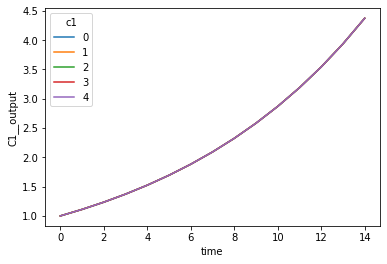

In [9]:
out_ds.C1__output.set_index(time='time').plot.line(x='time')

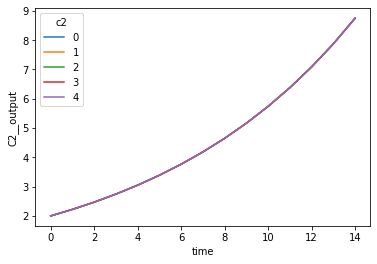

In [10]:
out_ds.C2__output.set_index(time='time').plot.line(x='time')